<a href="https://colab.research.google.com/github/ProfesorCamacho/Analisis_Estados_Financieros/blob/main/Analisis_de_estados_financieros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis de Estados Financieros para Análisis Bursátil**

Cuando buscamos empresas donde invertir nos encontramos con una infinidad de empresas listadas en la Bolsas de Valores. En este trabajo se enumeran tres criterios para analizar la solidez financiera de algunas empresas listadas en la Bolsa de Valores de Estados Unidos.

Importamos los modulos que se usaran en este análisis.
NOTA: Si no se utiliza Colab, se deberán instalar antes los módulos con pip install.

In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Al tener la base de datos proveniente de sqlite tenemos que generar la conexión para poder leer la base de datos y la tabla de dicha base de datos. Seleccionamos toda la tabla y que se imprima los primeros 5 renglones para explorar la base de datos.

In [25]:
# Ruta a la base de datos SQLite
ruta_base_de_datos = 'income_statements_select_07_21_.db'

# Nombre de la tabla a leer
nombre_tabla = 'Edo_Resultados'

# Conectar a la base de datos SQLite
conexion = sqlite3.connect(ruta_base_de_datos)

# Leer la tabla en un DataFrame
df = pd.read_sql_query(f'SELECT * FROM {nombre_tabla}', conexion)

# Cerrar la conexión
conexion.close()

# Mostrar los primeros 5 registros del DataFrame
print(df.head())

                  date symbol reportedCurrency        cik  \
0  2015-03-31 00:00:00     AA              USD  1675149.0   
1  2015-06-30 00:00:00     AA              USD  1675149.0   
2  2015-09-30 00:00:00     AA              USD  1675149.0   
3  2015-12-31 00:00:00     AA              USD  1675149.0   
4  2016-03-31 00:00:00     AA              USD  1675149.0   

           fillingDate         acceptedDate  calendarYear period  \
0  2015-03-31 00:00:00  2015-03-31 00:00:00        2015.0     Q2   
1  2015-06-30 00:00:00  2015-06-30 00:00:00        2015.0     Q2   
2  2015-09-30 00:00:00  2015-09-30 00:00:00        2015.0     Q3   
3  2015-12-31 00:00:00  2015-12-31 00:00:00        2015.0     Q4   
4  2016-03-31 00:00:00  2016-03-31 00:00:00        2016.0     Q2   

        revenue  costOfRevenue  ...  incomeBeforeTaxRatio  incomeTaxExpense  \
0  3.105000e+09   2.291000e+09  ...              0.132689       186000000.0   
1  2.964000e+09   2.352000e+09  ...              0.005735        4

La base de datos cuenta con 36 columnas donde 26 son las que tienen la información financiera  que nos interesa, y el resto es información adicional que nos ayuda a ubicar los datos como el nombre de la acción (symbol) y la fecha.

Ahora como notamos que tenemos diferentes empresas, vamos a ver cuantas empresas hay y cuantas observaciones (Estado de Resultados trimestral) tenemos para cada empresa.

In [26]:
# Contamos cuantas obvservaciones tenemos por empresa
conteo_empresas = df['symbol'].value_counts()
conteo_empresas

symbol
TILE    75
ASGN    73
LH      69
PPBI    68
T       68
        ..
BBL      2
LEV      2
THCB     2
TSIA     2
TBB      1
Name: count, Length: 1130, dtype: int64

Tenemos 1130 empresas en esta base de datos. y observaciones que  van desde 1 hasta 75. Sin embargo, para poder generar análisis  debemos quedarnos solo con las empresas que tienen más de 30 observaciones. De otro modo, no tendríamos datos suficientes para hacer conclusiones sobre los datos.

In [27]:
# Filtrar las empresas con al menos 30 observaciones
empresas_30_obs = conteo_empresas[conteo_empresas >= 30].index

# Filtrar el conjunto de datos para incluir solo estas empresas
empresas_interes = df[df['symbol'].isin(empresas_30_obs)]

empresas_interes.describe(include=object)

,date,symbol,reportedCurrency,fillingDate,acceptedDate,period,link,finalLink
count,44935,44935,44935,44935,44934,44935,37863,37859
unique,1134,821,15,3420,37708,5,37610,33983
top,2016-12-31 00:00:00,TILE,USD,2013-12-31 00:00:00,2013-12-31 00:00:00,Q1,https://www.sec.gov/Archives/edgar/data/165204...,https://www.sec.gov/Archives/edgar/data/165204...
freq,721,75,41498,188,188,11686,4,4


Nos quedamos con 821 empresas empresas diferentes con al menos 30 observaciones.

# **1. Ventas crecientes o constantes**

Empezaremos el anáslisis calculando la Tasa de Crecimiento Anual Compuesta o CAGR (Compound Annual Growth Rate) de los ingresos para cada empresa. Esta medida es ampliamente utilizada en finanzas para evaluar el crecimiento de una empresa, debido a que ayuda a suavizar los efectos de las fluctuaciones anuales y proporciona una visión clara del crecimiento a largo plazo. Lo que nos dice es el desempeño de la empresa en términos de generación de ingresos de manera consistente.

Como queremos sacar las empresas sólidas, nos quedaremos solo con las empresas que muestren un CAGR positivo en los ingresos.

In [30]:
# Trasformar las fechas a formato fecha datatime para poder operar
empresas_interes['date'] = pd.to_datetime(empresas_interes['date'])

# Filtrar las fechas mínimas y máximas para cada empresa
min_fecha = empresas_interes.groupby('symbol')['date'].min()
max_fecha = empresas_interes.groupby('symbol')['date'].max()

# Filtrar las ventas iniciales y finales para cada empresa
inicio_ventas = empresas_interes.groupby('symbol').apply(lambda x: x[x['date'] == min_fecha[x.name]]['revenue'].iloc[0])
fin_ventas = empresas_interes.groupby('symbol').apply(lambda x: x[x['date'] == max_fecha[x.name]]['revenue'].iloc[0])

# Calcular el número de años entre las fechas mínimas y máximas
años = (max_fecha - min_fecha).dt.days / 365

# Calcular el CAGR de ventas para cada empresa
cagr_ventas = ((fin_ventas / inicio_ventas) ** (1 / años)) - 1

# Filtrar empresas con CAGR positivo
cagr_positivo = cagr_ventas[cagr_ventas > 0]

cagr_positivo

<ipython-input-30-8620d6717dc3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  empresas_interes['date'] = pd.to_datetime(empresas_interes['date'])


symbol
AAL     0.035224
AAPL    0.209878
AAWW    0.075450
ABB     0.008507
ABCB    0.174854
          ...   
ZG      0.676855
ZION    0.009790
ZIXI    0.187021
ZNGA    0.183941
ZYXI    0.251780
Length: 713, dtype: float64

Con esto logramos descartar algunas empresas.

Vamos a generar un gráfico para ejempleficar que tipo de empresas queremos tener cuando nos referimos a CAGR de ingresos positivo.

<ipython-input-45-f01a606dcaaa>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=aapl, x='date', y='revenue', palette='viridis')


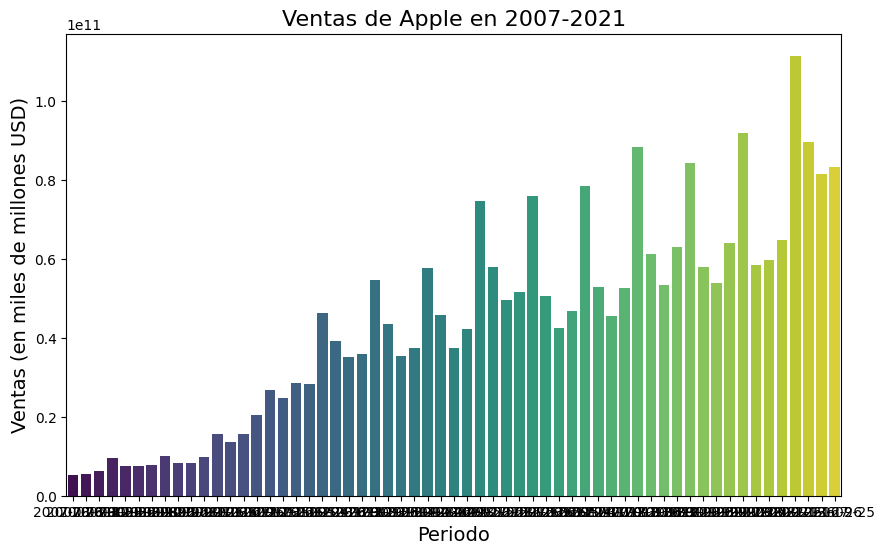

In [45]:
# Filtrar para una empresa
aapl = empresas_interes[empresas_interes['symbol'] == 'AAPL']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=aapl, x='date', y='revenue', palette='viridis')

# Añadir títulos y etiquetas
plt.title('Ventas de Apple en 2007-2021', fontsize=16)
plt.xlabel('Periodo', fontsize=14)
plt.ylabel('Ventas (en miles de millones USD)', fontsize=14)

# Mostrar el gráfico
plt.show()



El gráfico ilustra el crecimiento de las ventas de Apple de 2007 a 2021. Este comportamiento es lo que buscamos, una tendencia de crecimiento de largo plazo que ejemplifique un auge de las ventas. El CAGR nos ayuda a darle un valor numerico a esa cuestión.

# **2. No más de 8/60 Utilidad Neta negativa**

Ahora pondremos atención a la utilidad neta. Tener pérdidas en algunos trimestres no necesariamente indica que una empresa está en problemas si estas pérdidas son manejables y se producen en un contexto de declive general o eventos excepcionales.

Sin embargo no podemos permitir que esto suceda en repetidas ocaciones. Al estar analizando 60 trimestres, no podemos permitir más de 8 trimestres con pérdidas. De ser así, esto significa que la empresa puede enfrentar problemas temporales sin poner en riesgo su estabilidad a largo plazo. Empresas con pérdidas intermitentes pueden demostrar su capacidad de recuperarse y seguir siendo rentables a largo plazo.

In [32]:
max_8_negativos = []

for symbol, group in empresas_interes.groupby('symbol'):
    try:
        conteo_negativos = (group['netIncome'] < 0).sum()
        if conteo_negativos <= 8:
            max_8_negativos.append([symbol, conteo_negativos])
    except:
        continue

mun_negativos = pd.DataFrame(max_8_negativos, columns=["symbol", "num_negativos_netIncome"])
print(mun_negativos)

    symbol  num_negativos_netIncome
0     AAPL                        0
1      ABB                        1
2      ACN                        0
3     ADBE                        1
4      ADM                        0
..     ...                      ...
431     WU                        2
432    XOM                        4
433    XRX                        6
434   YNDX                        4
435     YY                        5

[436 rows x 2 columns]


Solo 436 empresas no registran mas de 8 periodos con pérdida en los últimos 15 años.

Ahora realizaremos un gráfico para demostras lo que buscamos.

<ipython-input-33-eaff560aa32c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xom, x='date', y='netIncome', palette='viridis')


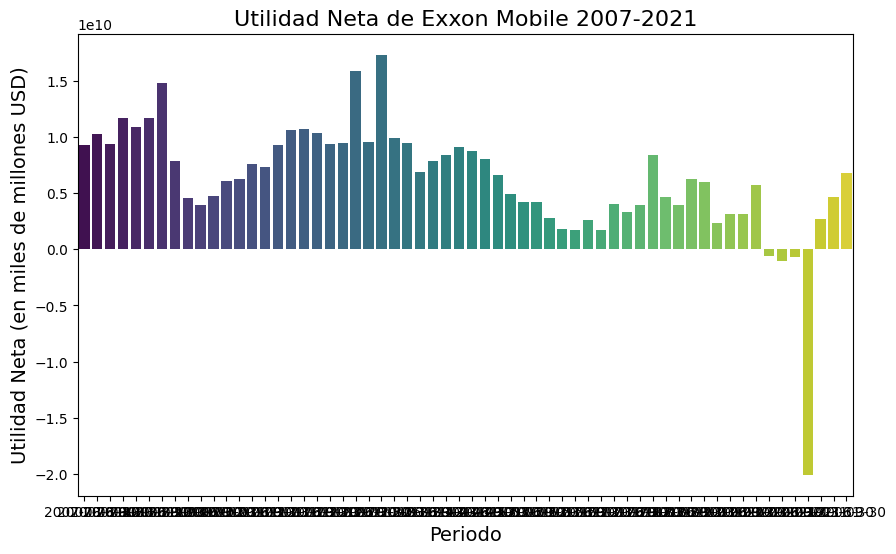

In [33]:
# Filtrar para una empresa
xom = empresas_interes[empresas_interes['symbol'] == 'XOM']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=xom, x='date', y='netIncome', palette='viridis')

# Añadir títulos y etiquetas
plt.title('Utilidad Neta de Exxon Mobile 2007-2021', fontsize=16)
plt.xlabel('Periodo', fontsize=14)
plt.ylabel('Utilidad Neta (en miles de millones USD)', fontsize=14)

# Mostrar el gráfico
plt.show()

El gráfico anterior ejemplifica que Exxon tuvo un periodo de pérdidas en los años de la pandemia Covid-19 y una recuperación en los ultimos trimestres registrados. Sin embargo, son muy pocas bajas (apenas 4) para pensar que Exxon esta quebrada, solo paso por un mal momento y sus utilidades hasta antes de esta situación eran simpre positivas. Por lo que considerariamos que cumple con la regla y se puede invertir en ella.

# **3. Mayor CAGR Ventas vs. Costos:**
Ahora volvemos a calcular el CAGR pero ahora para los costos de venta. Para despues compararlos con el CAGR de las ventas. Esto nos da una visión de cómo están creciendo las ventas en relación con los costos. La diferencia entre estos dos CAGRs puede revelar mucho sobre la eficiencia operativa y la facilidad de crear utilidad bruta a largo plazo de la empresa.

Obtendremos la diferencia entre ambos y nos quedaremos solo con los positivos. Esto represeta una gestión efectiva de los costos y la mejora en la eficiencia de las operaciones pueden contribuir a un crecimiento de los ingresos mayor que el de los costos.

In [34]:
# Filtrar las ventas iniciales y finales para cada empresa
inicio_costo = empresas_interes.groupby('symbol').apply(lambda x: x[x['date'] == min_fecha[x.name]]['costOfRevenue'].iloc[0])
fin_costo = empresas_interes.groupby('symbol').apply(lambda x: x[x['date'] == max_fecha[x.name]]['costOfRevenue'].iloc[0])

# Calcular el CAGR de los costos para cada empresa
cagr_costos = ((fin_costo / inicio_costo) ** (1 / años)) - 1

# Filtrar las empresas donde el CAGR de ingresos es mayor que el CAGR de los costos
diferencia = cagr_ventas - cagr_costos
mayor_cagr_ventas = diferencia[diferencia > 0]

mayor_cagr_ventas.to_csv("empresas")

Nos quedamos con solo 345 de empresas que cumplen la regla. Obviamente entre mayor sea la diferencia mejor, no obstante, basta con que sea positiva para ser buen indicador.

Ahora vamos a hacer un gráfico para ilustrar este indicador.


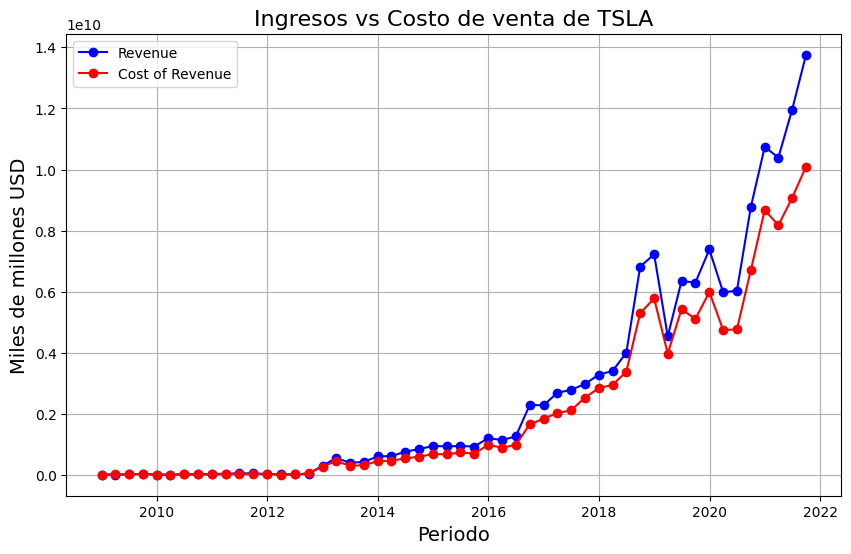

In [38]:
# Filtrar para una empresa
tsla = empresas_interes[empresas_interes['symbol'] == 'TSLA']

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
plt.plot(tsla['date'], tsla['revenue'], marker='o', linestyle='-', color='b', label='Revenue')
plt.plot(tsla['date'], tsla['costOfRevenue'], marker='o', linestyle='-', color='r', label='Cost of Revenue')

# Añadir títulos y etiquetas
plt.title('Ingresos vs Costo de venta de TSLA', fontsize=16)
plt.xlabel('Periodo', fontsize=14)
plt.ylabel('Miles de millones USD', fontsize=14)
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

En la gráfica se aprecia como los ingresos se separan mucho de los costos  despues de 2020. Además, nos ilustra como en los últimos años han crecido más rápido los ingresos que los costos.

# **Empresas que cumplen con las tres reglas**
Al final tenemos un grupo de empresas que al cumplir con estos criterios se vuelven confiables para inversiones de largo plazo. Es importante destacar que se debe analizar el instrumento de inversión de dicha empresa pero con este pequeño analisis se puede demostrar la fiabilidad y estabilidad de estas empresas.

In [36]:
# Convertir las Series en DataFrames
cagr_positivo_df = cagr_positivo.reset_index().rename(columns= {0 : "cagr_sales"})
mayor_cagr_ventas_df = mayor_cagr_ventas.reset_index().rename(columns={0: 'dif_cagrs'})

# Unir los DataFrames
empresas_solidas = cagr_positivo_df.merge(mun_negativos, on='symbol', how='inner')
empresas_solidas = empresas_solidas.merge(mayor_cagr_ventas_df, on='symbol', how='inner')

empresas_solidas

,symbol,cagr_sales,num_negativos_netIncome,dif_cagrs
0,AAPL,0.209878,0,0.009591
1,ABB,0.008507,1,0.001779
2,ACN,0.074651,0,0.005891
3,ADS,0.048986,1,0.018862
4,AMN,0.080875,8,0.009901
...,...,...,...,...
161,WNS,0.064358,3,0.011100
162,WOR,0.041409,6,0.005303
163,WRK,0.160672,4,0.000409
164,WTS,0.019048,6,0.010711


# **Conclusiones**

Empezamos con 821 empresas y nos quedamos al final con 166. Esto quiere decir que tenemos certeza de la fiabilidad y la estabilidad de estas empresas, reduciendo el universo de inversión a empresas que tendran mejores resultados.

Es importante destacar que se debe analizar el instrumento de inversión de dicha empresa, pues este análisis escapa de muchas otras variables afectan esos instrumentos.